Your Name and PRN:
- Name: ______________________
- PRN : ______________________
- Date: ______________________

# CNN
## Assignment A07

In [3]:
#!/usr/bin/env pyhton3
# -*- coding 

from sklearn import datasets
from sklearn.model_selection import train_test_split
###-----------------
### Import Libraries
###-----------------
import os
import time
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix
import gc
import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import tensorflow as tf
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Introduction to tensorFlow Fashion  dataset
- multi class
- reLU
- swish


In [6]:
# Global variables
inpDir = './input' # Input Stored here
outDir = './ouput' # output Here
modelDir = './models'# to save Models
subDir = 'fashion_mnist' # sub dir by dataset
RANDOM_STATE = 24
np.random.RandomState(seed = RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
#rng = np.random.default_rng(seed = RANDOM_STATE)
#N_SAMPLE = 1000
TEST_SIZE = 0.2 # 18147 - 56*256
ALPHA = 0.001 # learning rate
NOISE = 0.2 # Error
EPOCHS = 100
BATCH_SIZE = 32

PATIENCE = 30
LR_FACTOR  =0.1
LR_PATIENCE = 20

In [7]:
# tf.random.set_seed?


In [8]:
# inpDir = './input'
# outDir = './output'

In [9]:
#set the plotting parameters
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }
    #'text.usetex':True,

plt.rcParams.update(params)
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')


## Load Fashion MNIST dataset


This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [11]:
# train_df = pd.read_csv(os.path.join(inpDir,'fashion-mnist_train.csv'))

In [12]:
def fn_plot_torch_hist(hist_df):
    
    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))
    
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]
    
    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset='test_loss')
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);
    
    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot
        
    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow
    
    
    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(), 
               color = 'green', 
               linestyle='-.', lw = 3)
    
    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid(True)
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()



In [13]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

In [14]:
train_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
train_df.isnull().sum().sum(), test_df.isnull().sum().sum()

(0, 0)

In [17]:
train_df.columns

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

In [18]:
# def fn_plot_labels(train_df: pd.DataFrame, test_df: pd.DataFrame):
#     '''
#     Args:
#         train_df: pd.DataFrame - Data for training
#         test_df : pd.DataFrame - Data for validation
#     return:
#         None
#     '''
#     # plotting class distibution of Train set
#     plt.subplots(1,2,1)
#     ax = train_df['labels'].value_counts().plot(kind='bar',
#                                                title = 'Train_Distribution',
#                                                color = 'DarkBlue',
#                                                alpha = 0.8)

#     # plotting class distribution of validation set
#     plt.subplots(1,2,2)
#     ax = test_df['labels'].value_counts().plot(kind='bar',
#                                                title = 'Test_Distribution',
#                                                color = 'Orange',
#                                                alpha = 0.8)

In [19]:
def fn_plot_labels(train_df: pd.DataFrame, test_df: pd.DataFrame):
    """
    Args:
        train_df: pd.DataFrame - Data for training
        test_df : pd.DataFrame - Data for validation
    Returns:
        None
    """
    # Create a single figure with 1 row and 2 columns of subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed
    
    # Plotting class distribution of Train set
    train_df['label'].value_counts().plot(
        kind='bar',
        title='Train Distribution',
        color='DarkBlue',
        alpha=0.8,
        ax=axes[0]  # Use the first subplot
    )
    
    # Plotting class distribution of Test set
    test_df['label'].value_counts().plot(
        kind='bar',
        title='Test Distribution',
        color='Orange',
        alpha=0.8,
        ax=axes[1]  # Use the second subplot
    )
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()


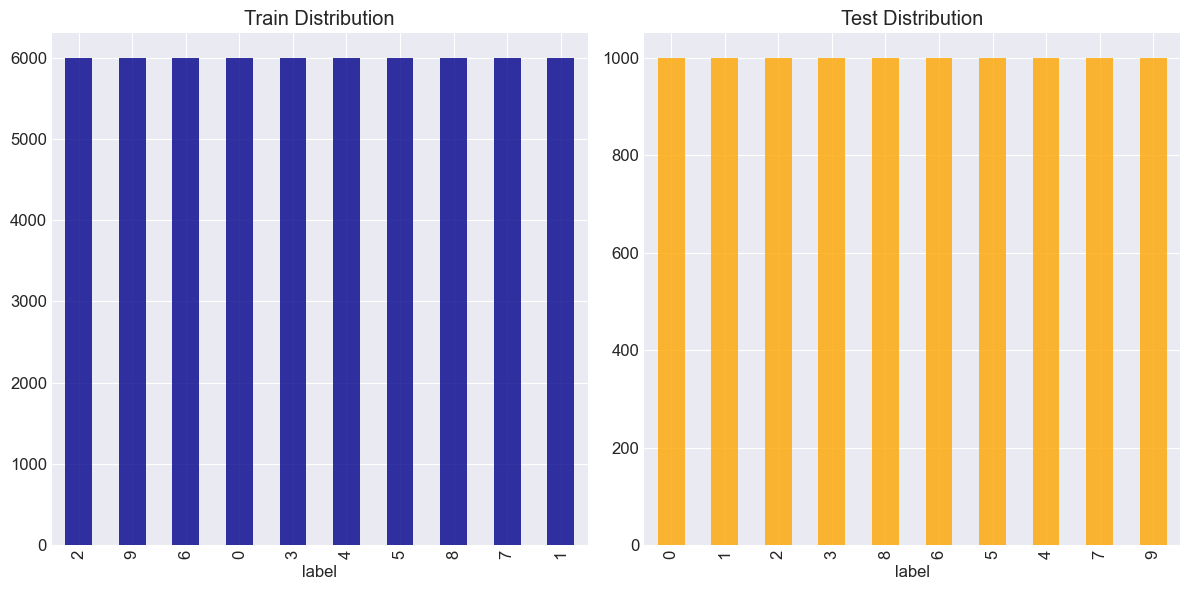

In [20]:
fn_plot_labels(train_df = train_df, test_df = test_df)

* Convert into Datasets 

In [22]:
def split_feature_label(row):
    '''
    args:
        row: array with 785 values
    return:
        features: np.ndarray of shape 28*28*1
        labels: integer
    '''
    # take values from index 1 onwards and reshape to image 
    
    features = tf.reshape(row[1:], [28,28,1])
    # take first value as label
    labels = row[0]
    return features, labels

In [23]:
# create dataset
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)
train_ds = tmp_ds.map(split_feature_label)
train_ds = train_ds.batch(BATCH_SIZE)


tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)
test_ds = tmp_ds.map(split_feature_label)
test_ds = test_ds.batch(BATCH_SIZE)

In [24]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

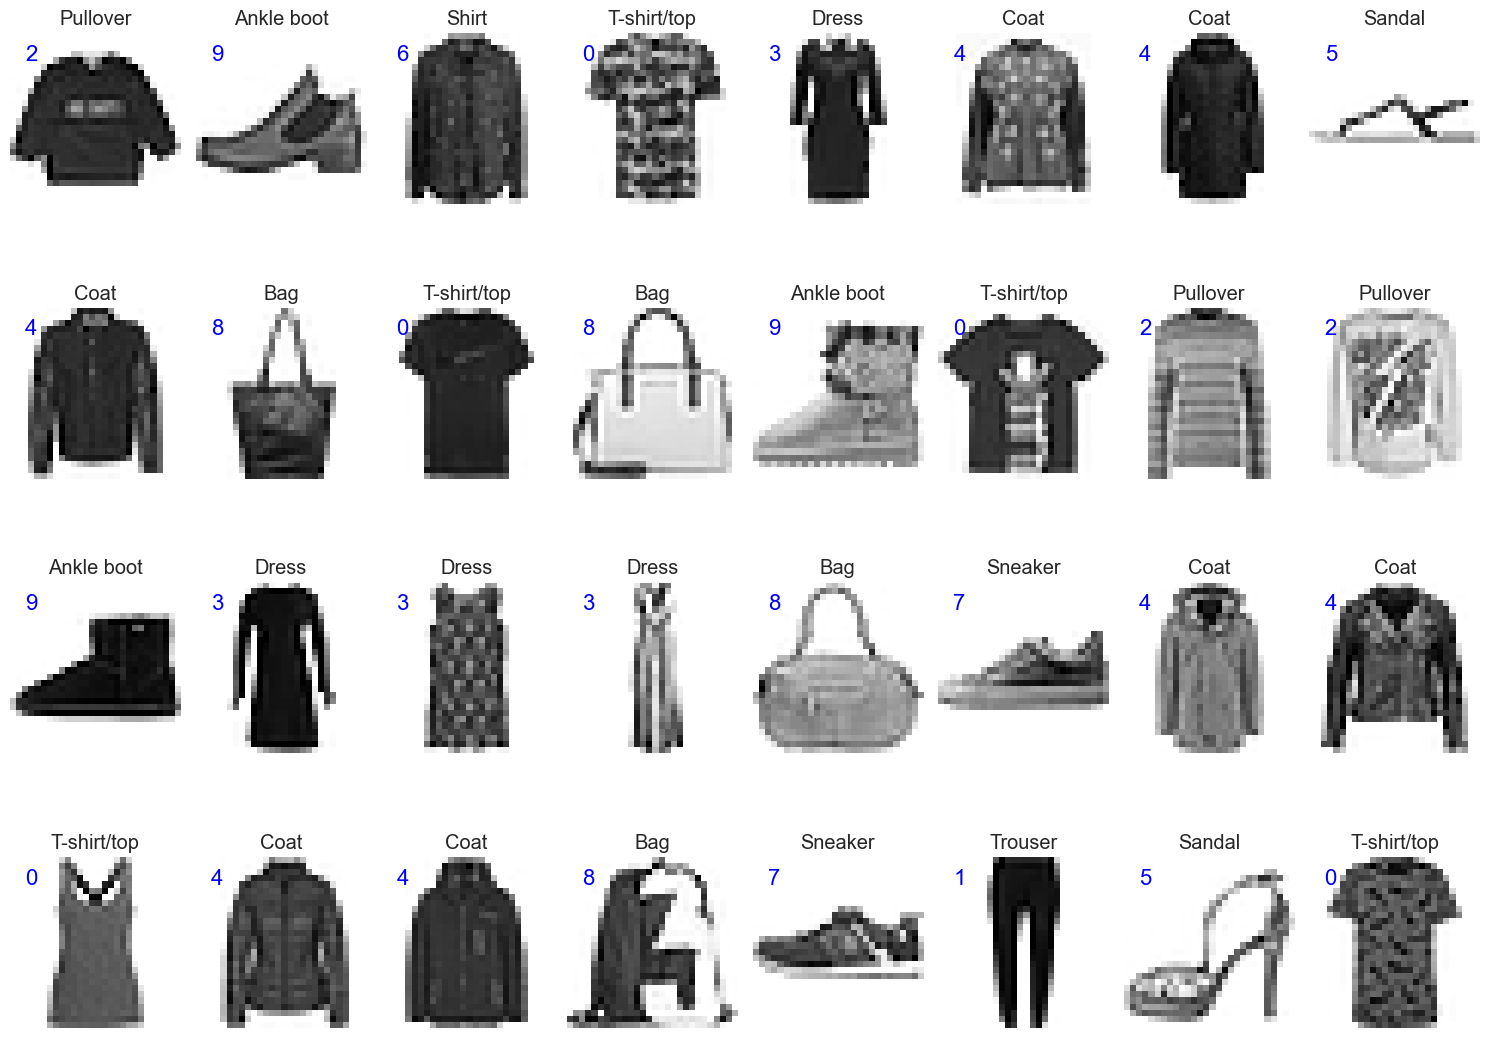

In [25]:
# sample DATA plot: Display a grid of images from the dataset along with their labels



#create a new figure for the grid of images with a specified size
fig = plt.figure(figsize  =(15,12))

#Adjust Margins
fig.subplots_adjust(left = 0, right = 1, bottom=0, top = 1, hspace =0.05, wspace = 0.05)
i= 0 
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(BATCH_SIZE// 8,8, i+1)
        plt.grid(False)

        plt.imshow(images[i].numpy().astype('uint8'), cmap = plt.cm.binary)
        
        # Add the numeric label to the image in blue text at a specific position
        plt.title(class_names[labels[i].numpy()])
        
        
        # Add the class name of the image in red text below the numeric label 
        plt.text(2,4, labels[i].numpy(), color = 'b', fontsize=16)
    #SWITCH OF AXIS   
        plt.axis('off')
plt.tight_layout()
#Display the entire frid of images
plt.show()

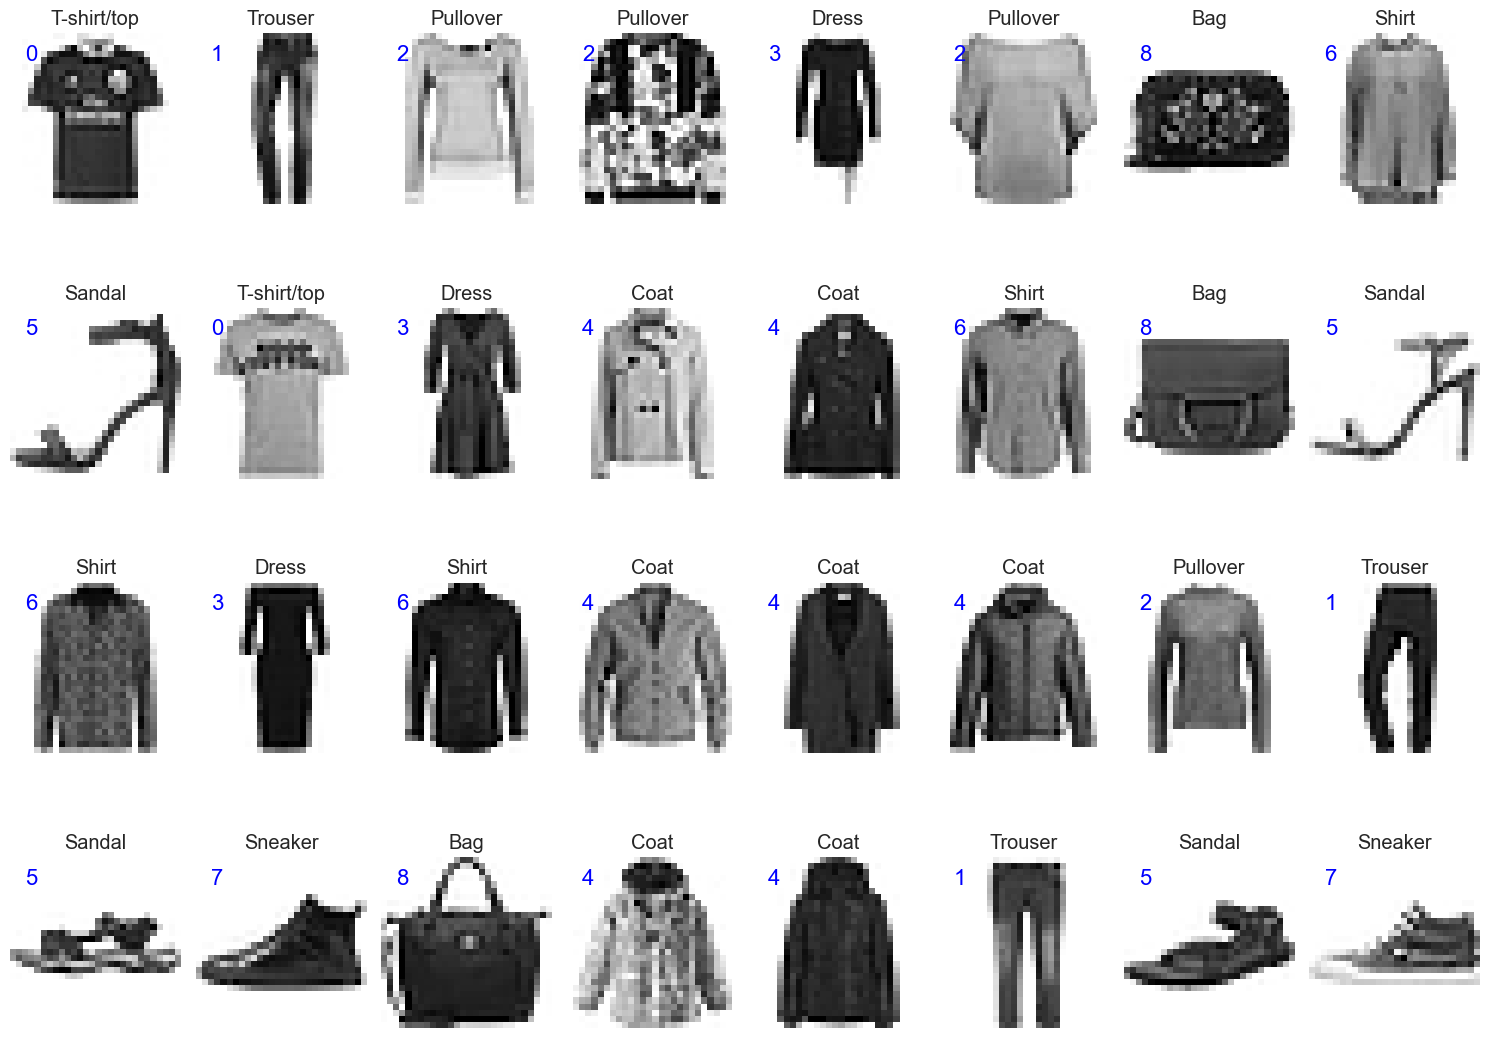

In [26]:
# sample DATA plot: Display a grid of images from the dataset along with their labels



#create a new figure for the grid of images with a specified size
fig = plt.figure(figsize  =(15,12))

#Adjust Margins
fig.subplots_adjust(left = 0, right = 1, bottom=0, top = 1, hspace =0.05, wspace = 0.05)
i= 0 
for images, labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(BATCH_SIZE// 8,8, i+1)
        plt.grid(False)

        plt.imshow(images[i].numpy().astype('uint8'), cmap = plt.cm.binary)
        
        # Add the numeric label to the image in blue text at a specific position
        plt.title(class_names[labels[i].numpy()])
        
        
        # Add the class name of the image in red text below the numeric label 
        plt.text(2,4, labels[i].numpy(), color = 'b', fontsize=16)
    #SWITCH OF AXIS   
        plt.axis('off')
plt.tight_layout()
#Display the entire frid of images
plt.show()

In [27]:
# images[i].numpy().max()
norm_layer = tf.keras.layers.Rescaling(1/255.)

img_batch, lbl_batch = next(iter(train_ds))
#img_batch.shape, lbl_batch.shape
norm_ds = train_ds.map(lambda x,y:(norm_layer(x), y))

img_batch, lbl_batch = next(iter(norm_ds))
display(img_batch[0].numpy().min(), img_batch[0].numpy().max())

del norm_ds

0.0

1.0

In [28]:
train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [29]:
#Convolution Layer

<Axes: >

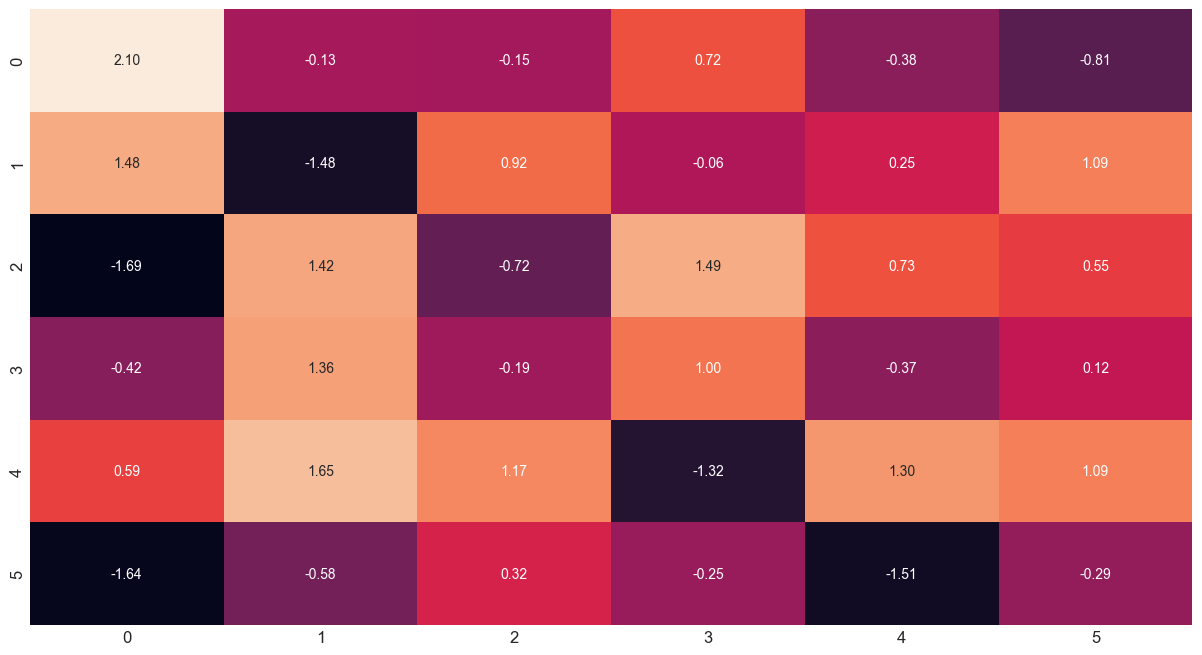

In [30]:
input_shape = (1,6,6,1) # [Batch, H, W, C]
X = tf.random.normal(input_shape)

sns.heatmap(X.numpy()[0, :, :, 0], annot = True, fmt = '.2f', cbar = False )

In [31]:
y = tf.keras.layers.Conv2D(1, 3, 
                   kernel_initializer = tf.constant_initializer(1.0),
                          use_bias =False,
                          activation='relu')(X)

<Axes: >

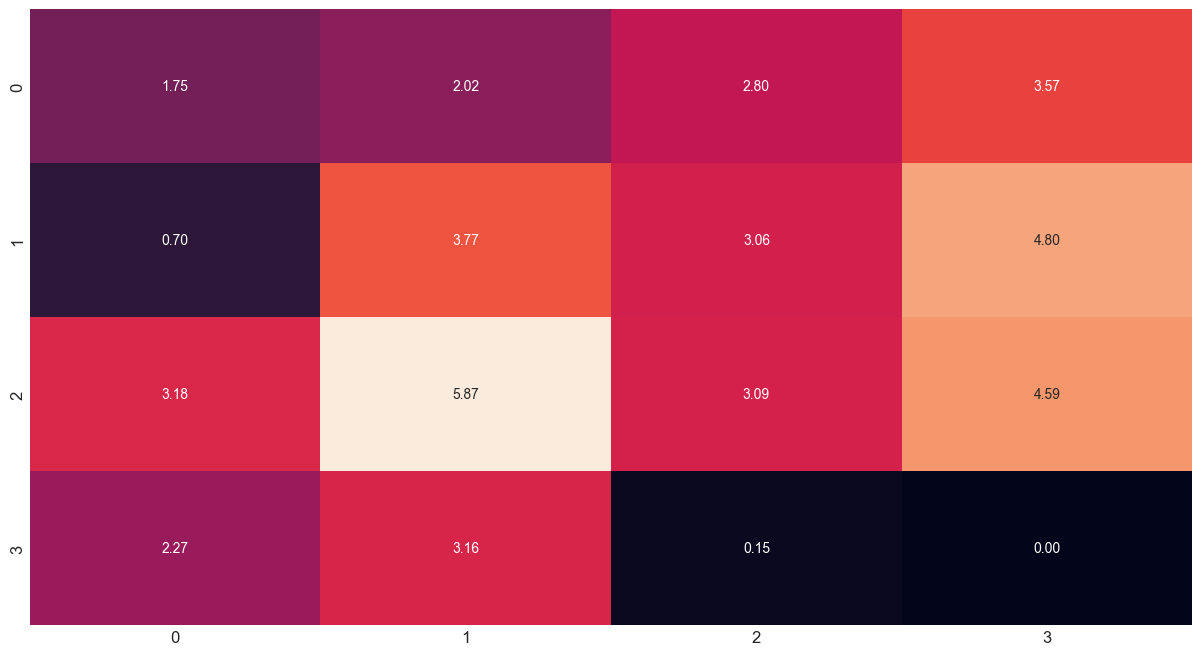

In [32]:
sns.heatmap(y.numpy()[0, :, :, 0], annot = True, fmt = '.2f', cbar = False )

In [33]:
max_pool = tf.keras.layers.MaxPool2D(pool_size = (2,2),
                                     strides = (2,2), 
                                     padding = 'valid')
z = max_pool(y)

<Axes: >

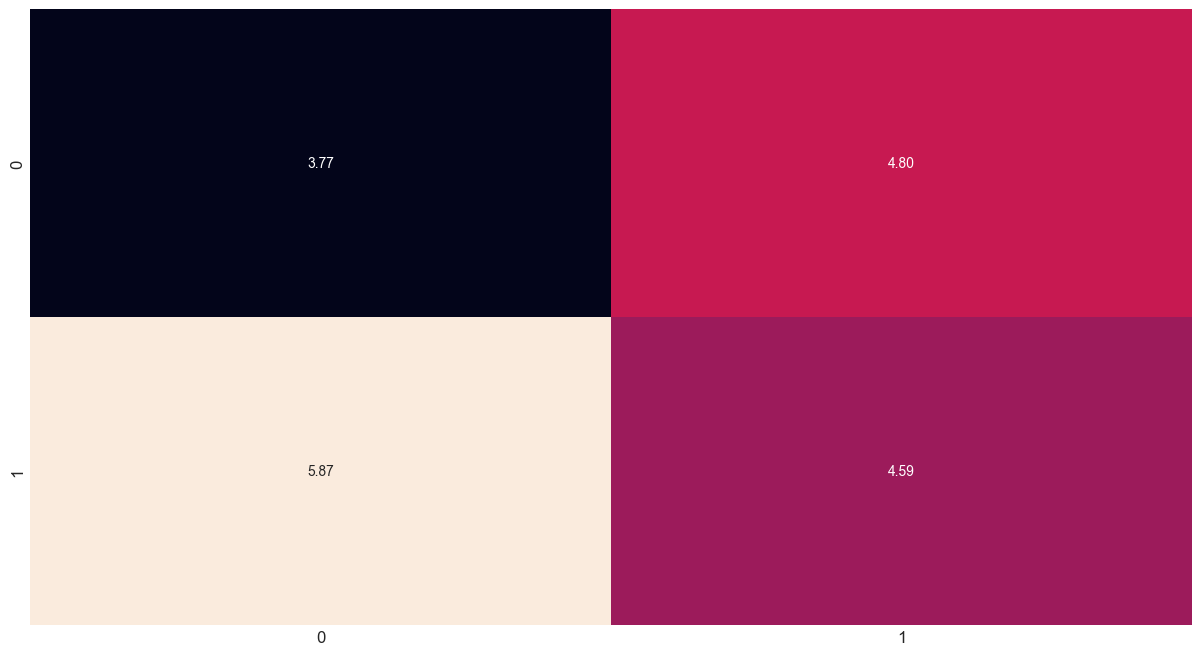

In [34]:
sns.heatmap(z.numpy()[0, :, :, 0], annot = True, fmt = '.2f', cbar = False )

In [35]:
krnl_initializer =tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

input_shape = (28,28,1)

inputs = tf.keras.Input(shape = input_shape, name = 'input')
x = tf.keras.layers.Rescaling(1./255.)(inputs)


##....
#Set1
#conv

x = tf.keras.layers.Conv2D(32, (3,3), kernel_initializer=krnl_initializer,
                          padding='same',
                          activation=tf.keras.activations.relu,
                          name = 'conv_1')(x) #o/p (28,28,32)

# MAxpool
x = tf.keras.layers.MaxPool2D((2,2), name='mp_1')(x) #o/p (14,14,32)

#Set2
#conv

x = tf.keras.layers.Conv2D(64, (3,3), kernel_initializer=krnl_initializer,
                          padding='same',
                          activation=tf.keras.activations.relu,
                          name = 'conv_2')(x) #o/p (12,12,64)

# MAxpool
x = tf.keras.layers.MaxPool2D((2,2), name='mp_2')(x) #o/p (6,6,64)


#Set3
#conv

x = tf.keras.layers.Conv2D(128, (3,3), kernel_initializer=krnl_initializer,
                          padding='same',
                          activation=tf.keras.activations.relu,
                          name = 'conv_3')(x) #o/p (4,4,128)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(128,activation=tf.keras.activations.relu,
                         name = 'fc_1')(x)
outputs = tf.keras.layers.Dense(10,
                               name = 'output')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'MNIST')
model.summary()





Model: "MNIST"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mp_1 (MaxPooling2D)                  │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mp_2 (MaxPooling2D)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 128)                 │         802,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 896,906 (3.42 MB)

 Trainable params: 896,906 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# tf.keras.utils.plot_model(
#     model, 
#     os.path.join(outDir, 'mnist_dataset.png'),
#     show_shapes=True, 
#     show_dtype=True, 
#     show_layer_activations=True
# )



In [37]:
# compling the model after defining the adam and loss functions
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:

history = model.fit(train_ds, epochs=10, validation_data=test_ds)

# results and inferences
hist_df = pd.DataFrame(history.history) 

display(hist_df.head(3))
display(hist_df.tail(3))



Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - accuracy: 0.8022 - loss: 0.5385 - val_accuracy: 0.8899 - val_loss: 0.2933
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9026 - loss: 0.2640 - val_accuracy: 0.9103 - val_loss: 0.2572
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9223 - loss: 0.2088 - val_accuracy: 0.9189 - val_loss: 0.2383
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9372 - loss: 0.1678 - val_accuracy: 0.9150 - val_loss: 0.2569
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9509 - loss: 0.1315 - val_accuracy: 0.9178 - val_loss: 0.2618
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9611 - loss: 0.1044 - val_accuracy: 0.9177 - val_loss: 0.2808
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - accuracy: 0.9681 - loss: 0.0850 - val_accuracy: 0.9192 - val_loss: 0.3240
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9730 -

,accuracy,loss,val_accuracy,val_loss
0,0.858067,0.387234,0.8899,0.293278
1,0.907567,0.249557,0.9103,0.257212
2,0.926483,0.198628,0.9189,0.238319


,accuracy,loss,val_accuracy,val_loss
7,0.973483,0.071497,0.9121,0.382941
8,0.976700,0.062122,0.9161,0.396433
9,0.979717,0.054495,0.9213,0.380064


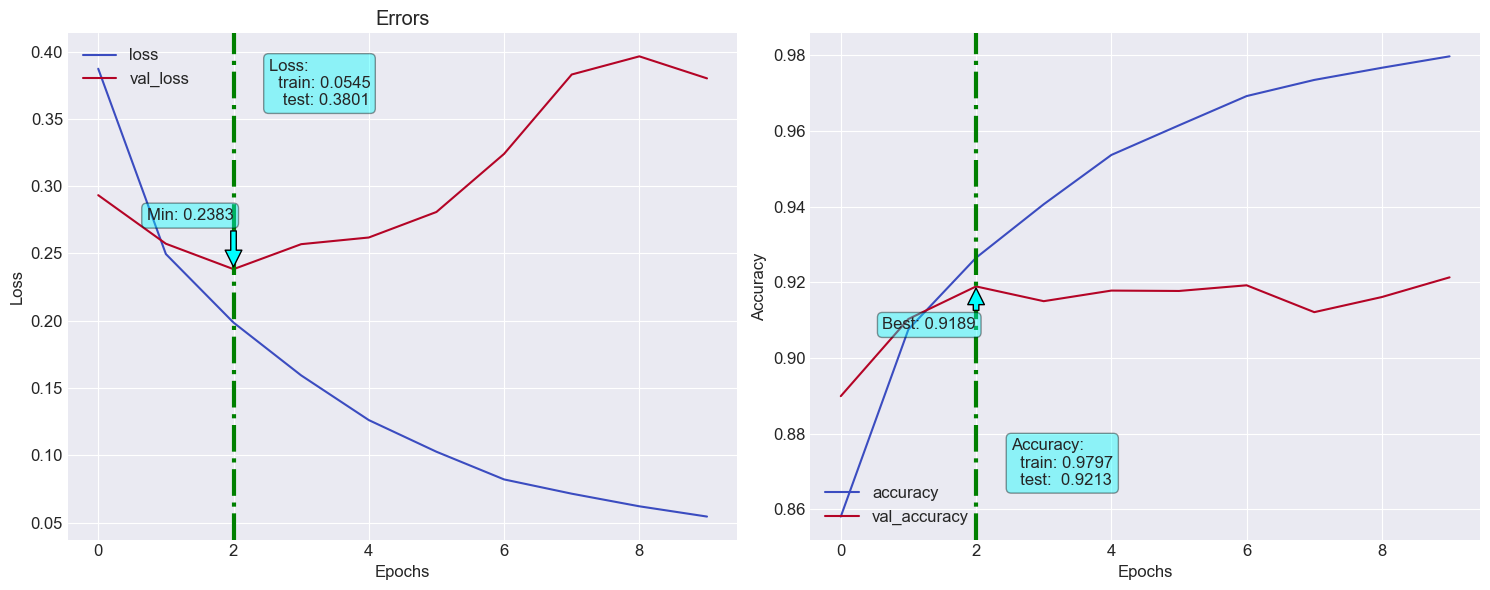

In [39]:
fn_plot_tf_hist(hist_df = hist_df)
